# Modeling Energy Levels with Neural Networks

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes.

This notebook uses the ENSDF Dataset and builds a model to predict the level energy of several isotopes. To do this, we'll provide the model with a description of many expeirmentally measrued values and accepted values. This description includes attributes like: # of neutrons, # of protons, and Atomic Mass.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

2.0.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Getting the Data: Cross Sections

In [5]:
print("Reading data into dataframe...")
df = pd.read_csv("./ensdf_v1.csv")
print("Data read into dataframe!")

# Converting specific columns to datatype 'string'
str_cols = ["Spin", "Parity", "Element_w_A", "Element"]
df[str_cols] = df[str_cols].astype('category')

# Converting remaining columns to numeric type. 
for col in list(df.columns):
    if col not in str_cols:
        df[col] = df[col].astype(float)

# Converting proton, neutron and mass number features to integers
int_cols = ["Level_Number", "Protons", "Target_Neutrons", "Target_Mass_Number"]
df[int_cols] = df[int_cols].astype(int)

Reading data into dataframe...
Data read into dataframe!


In [6]:
df.columns

Index(['Level_Number', 'Level_Energy', 'Spin', 'Parity', 'Element_w_A',
       'Protons', 'Target_Neutrons', 'Atomic_Mass_Micro', 'Target_Mass_Number',
       'Element'],
      dtype='object')

In [7]:
df.shape

(72668, 10)

In [8]:
basic_cols = ["Level_Number", "Level_Energy", "Protons", "Target_Neutrons", "Atomic_Mass_Micro"]
df = df[basic_cols]

In [9]:
df.head()

,Level_Number,Level_Energy,Protons,Target_Neutrons,Atomic_Mass_Micro
0,1,0.0,0,1,1.008665e+06
1,1,0.0,1,0,1.007000e+00
2,1,0.0,1,1,2.014102e+06
3,1,0.0,1,2,3.016049e+06
4,1,0.0,2,1,3.016029e+06


# One-Hot-Encoding of Categorical Data 

Categorical data can be represented by either assigning a numerical value to each category or by a sparse binary matrix where a `1` is placed when the category is present. We opted for the latter. In this case the categorical features include:

> `MT`: which refers to the ENDF reaction number. 

> `spin`: 

> `parity`

In [10]:
# # Specify categorical variables calculating one-hot-encode features 
# # The useful categorical feature can also be Out, in this case we use OUT
# cat_cols = ["MT", "spin", "parity"]
# df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EA10BFFAC8>,
      dtype=object)

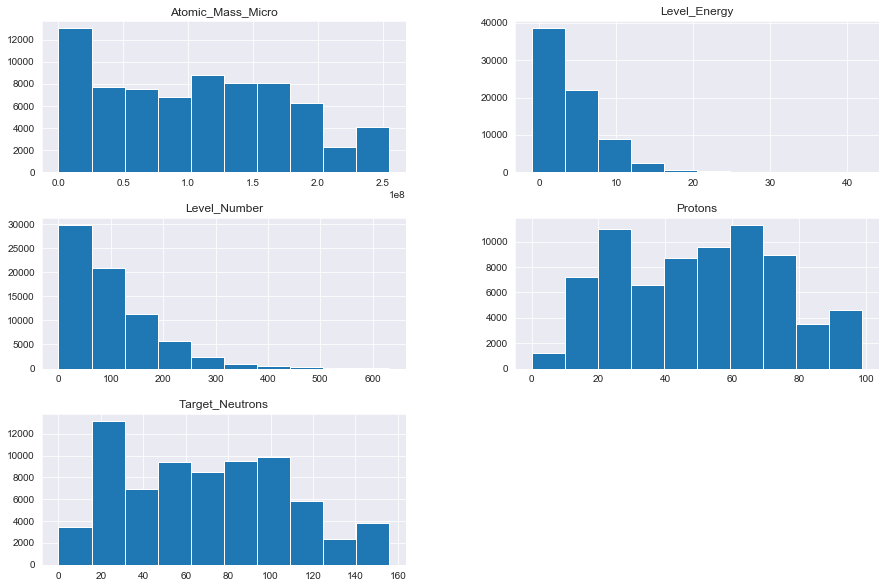

In [11]:
df.hist(figsize=(15,10))

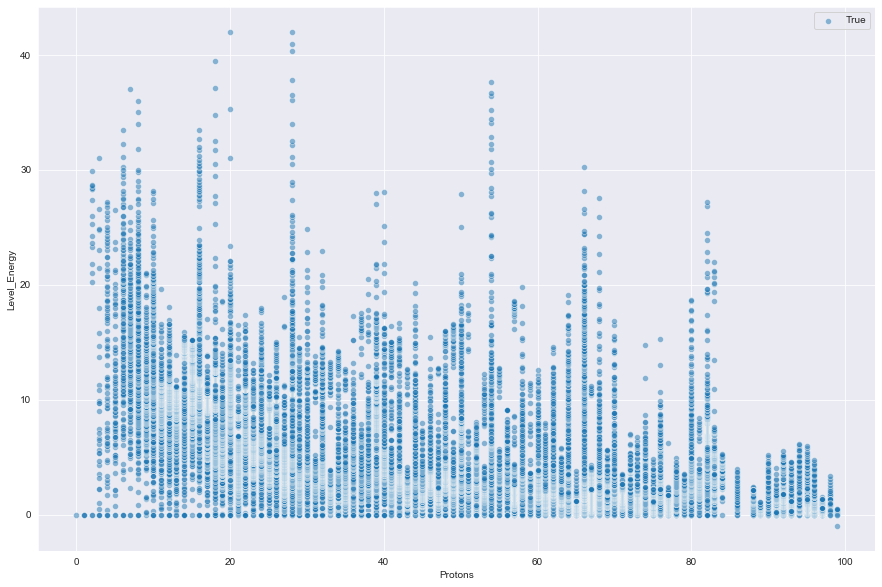

In [12]:
plt.figure(figsize=(15,10))
sns.scatterplot(df["Protons"], df["Level_Energy"], alpha=0.5, label="True")

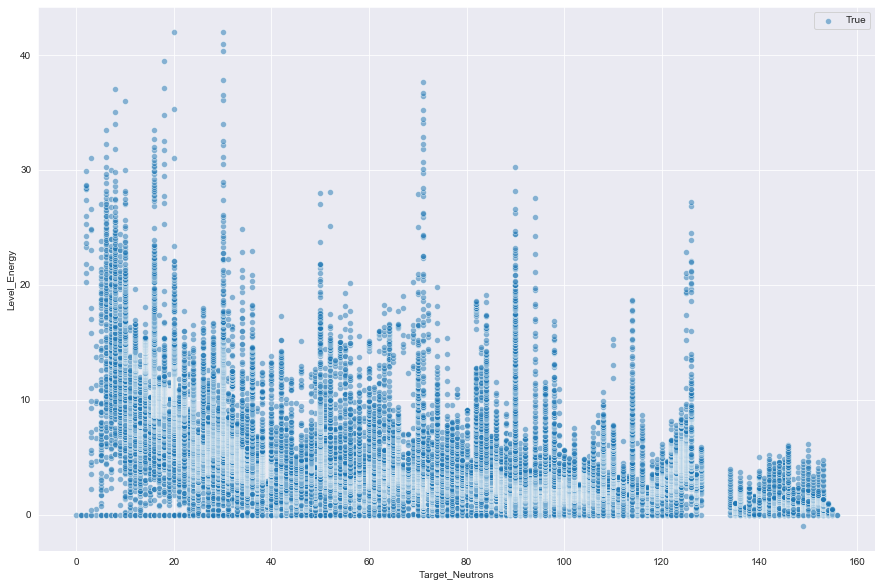

In [13]:
plt.figure(figsize=(15,10))
sns.scatterplot(df["Target_Neutrons"], df["Level_Energy"], alpha=0.5, label="True")

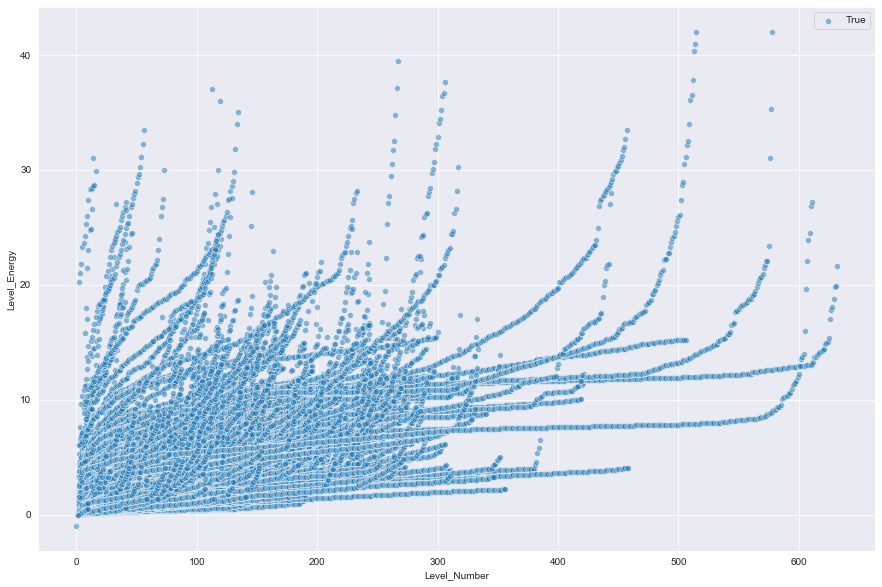

In [14]:
plt.figure(figsize=(15,10))
sns.scatterplot(df["Level_Number"], df["Level_Energy"], alpha=0.5, label="True")

In [15]:
def plot_levels_axh(protons, neutrons):
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(10,15))
    for i in to_plot["Level_Energy"].values:
        plt.axhline(i, c="r", alpha=0.5)
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    
def plot_levels_sctr(protons, neutrons):
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
    sns.scatterplot(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.5, label="True")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')

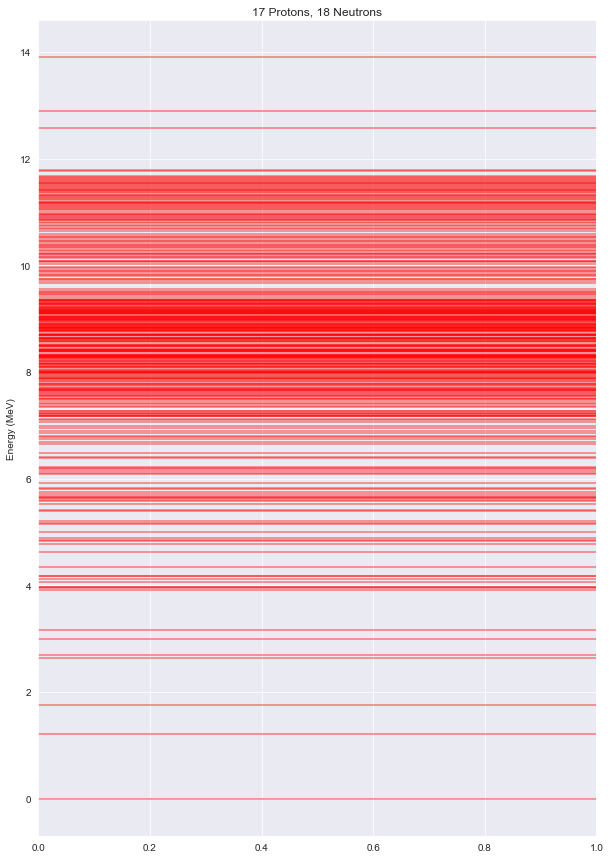

In [16]:
plot_levels_axh(17, 35-17)

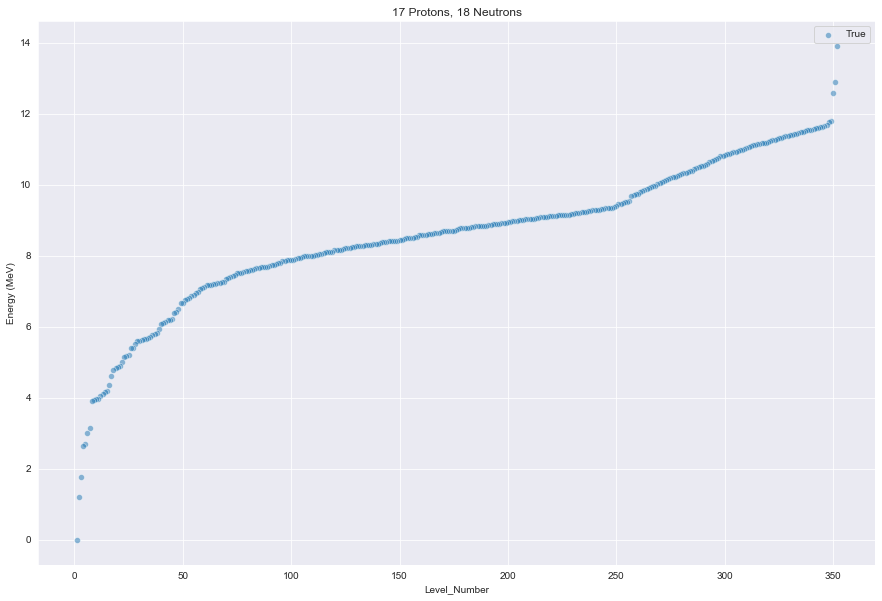

In [17]:
plot_levels_sctr(17, 35-17)

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

# Creating Training, Validation, and Testing Datasets

In [19]:
from sklearn.model_selection import train_test_split

In [27]:
train_size = 0.8
test_size = 1 - 0.8
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Level_Energy"], axis=1), df["Level_Energy"], test_size=0.20)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [28]:
from sklearn import preprocessing

In [29]:
# Specify columns to scale
to_scale = list(x_train.columns)
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])

In [30]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [31]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Level Energy (MeV)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [50]:
def predicting_nuclear_xs(protons, neutrons, clf, tf_dataset=False):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, N).
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True)
    to_infer = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns="Level_Energy")

    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
    
    if tf_dataset == True:
        infer_dataset = tf.data.Dataset.from_tensor_slices(
            (to_infer.values, to_plot["Level_Energy"].values)).shuffle(len(x_test)).batch(global_batch_size)
        y_hat  = clf.predict(infer_dataset)
    # Making Prediction with given model
    else:
        y_hat  = clf.predict(to_infer.values)
    
    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='b')
    pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="orange")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Level Energy (MeV)')
    plt.xlabel('Level Number')
    plt.legend((true, pred), ('ENSDF', "NN ENSDF Pred"), loc='upper left')    
    all_y = np.concatenate((to_plot["Level_Energy"], y_hat[0]))
    minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
    maximum_y = all_y.max() + all_y.max() * 0.05
    plt.ylim(minimum_y, maximum_y)
    plt.show()
    
    # Measuring metrics on predictions.
    print("XS Tree vs EXFOR:")
    print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
    print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))

# Neural Networks

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

The strategy.scope() indicates part of the code to run distributed, creating model inside scope allows us to create mirrored vairables, compiling under the scope tells TF our intend to train model using this strategy.

In [35]:
size_histories = {}
size_histories_gpu = {}

In [ ]:
# tf.distribute.HierarchicalCopyAllReduce and tf.distribute.ReductionToOneDevice
mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

In [39]:
BUFFER_SIZE = len(x_train)
BATCH_SIZE_PER_REPLICA = 128
global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)

data_len = x_train.shape[0]
feature_len = x_train.shape[1]
STEPS_PER_EPOCH = int((data_len * train_size)//global_batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.values, y_train.values)).shuffle(len(x_train)).batch(global_batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.values, y_test.values)).batch(len(x_test))


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# monitor: quantity to be monitored and epochs with no imporvement after which training will be stopped
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit_gpu(model, name, x, optimizer=None, max_epochs=10000, VERBOSE=0):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    model.summary()
    history = model.fit(x, shuffle=True,
        # steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs, validation_data=test_dataset, verbose=VERBOSE,
        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    return history

In [40]:
with mirrored_strategy.scope():
    tiny_model = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=[feature_len]),
        layers.Dense(1)])
    size_histories['tiny'] = compile_and_fit_gpu(tiny_model, 'sizes/Tiny', train_dataset, max_epochs=1000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:21.9812,  mae:3.5561,  mse:21.9824,  val_loss:11.7828,  val_mae:2.4513,  val_mse:11.7828,  
....................................................................................................
Epoch: 100, loss:4.1392,  mae:1.2649,  mse:4.1399,  val_loss:4.4535,  val_mae:1.2962,  val_mse:4.4535,  
....................................................................................................
Epoch: 200, loss:3.9108,  mae:1.2356,  mse:3.9116,  val_loss:4.2363,  val_mae:1.2580,  val_mse:4.2363,  


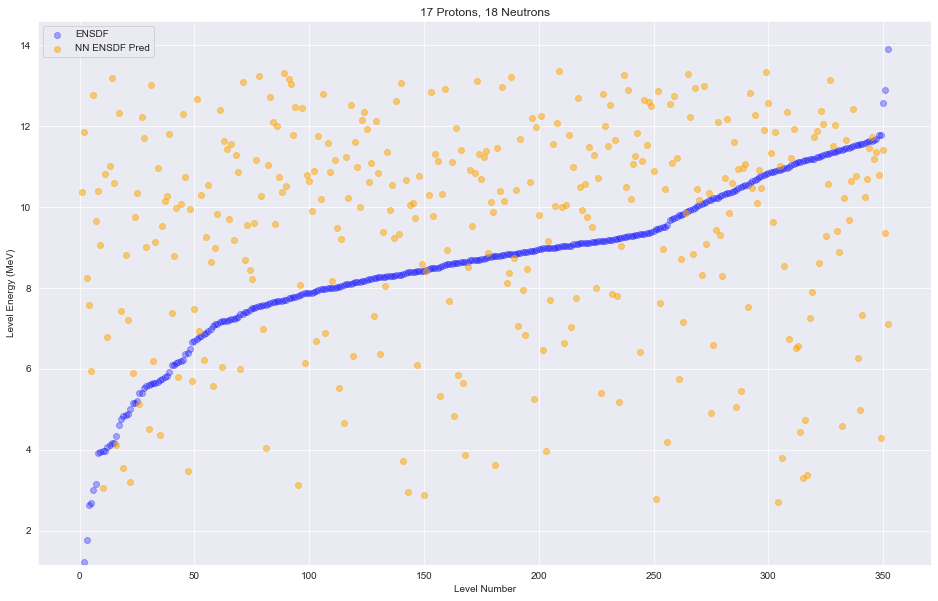

XS Tree vs EXFOR:
The MSE is:  11.3147701609144
The R2-Score is:  -1.7556958043951254


In [41]:
# FOR THIS TO WORK WE NEED TO MODIFY FUNCTION TO HANDLE DATSETS
predicting_nuclear_xs(17, 35-17, size_histories['tiny'].model, tf_dataset=True)

# Second Strategy

In [135]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE) 
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values)).batch(GLOBAL_BATCH_SIZE) 

# train_dist_dataset = mirrored_strategy.experimental_distribute_dataset(train_dataset)
# test_dist_dataset = mirrored_strategy.experimental_distribute_dataset(test_dataset)

# I NEED TO ADD .repeat().batch()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values)).shuffle(len(x_train)).batch(GLOBAL_BATCH_SIZE)
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val.values, y_val.values)).shuffle(len(x_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values)).shuffle(len(x_test)).batch(GLOBAL_BATCH_SIZE)

In [44]:
# monitor: quantity to be monitored and epochs with no imporvement after which training will be stopped
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit(model, name, x, y, optimizer=None, max_epochs=10000, VERBOSE=0):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    model.summary()
    history = model.fit(x, y,
        batch_size=BATCH_SIZE, shuffle=True,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs, validation_split=0.2, verbose=VERBOSE,
        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    return history

def compile_and_fit_gpu(model, name, x, optimizer=None, max_epochs=10000, VERBOSE=0):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    model.summary()
    history = model.fit(x, y, shuffle=True,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs, validation_split=0.2, verbose=VERBOSE,
        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    return history

In [45]:
with mirrored_strategy.scope():
    tiny_model_np = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=[feature_len]),
        layers.Dense(1)])
    size_histories['tiny_np'] = compile_and_fit(tiny_model, 'sizes/Tiny_np', x_train.values, y_train.values, max_epochs=1000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:3.4269,  mae:1.1641,  mse:3.4269,  val_loss:3.4067,  val_mae:1.1623,  val_mse:3.4063,  
....................................................................................................
Epoch: 100, loss:3.3725,  mae:1.1415,  mse:3.3724,  val_loss:3.3138,  val_mae:1.1245,  val_mse:3.3134,  
....................................................................................................
Epoch: 200, loss:3.1195,  mae:1.1060,  mse:3.1195,  val_loss:3.1950,  val_mae:1.1192,  val_mse:3.1946,  
....

Text(0, 0.5, 'MSE [XS^2]')

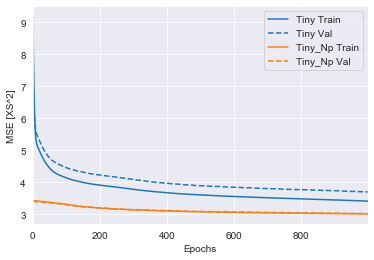

In [46]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mse', smoothing_std=5)
plotter.plot(size_histories)
plt.ylim()
plt.ylabel('MSE [XS^2]')

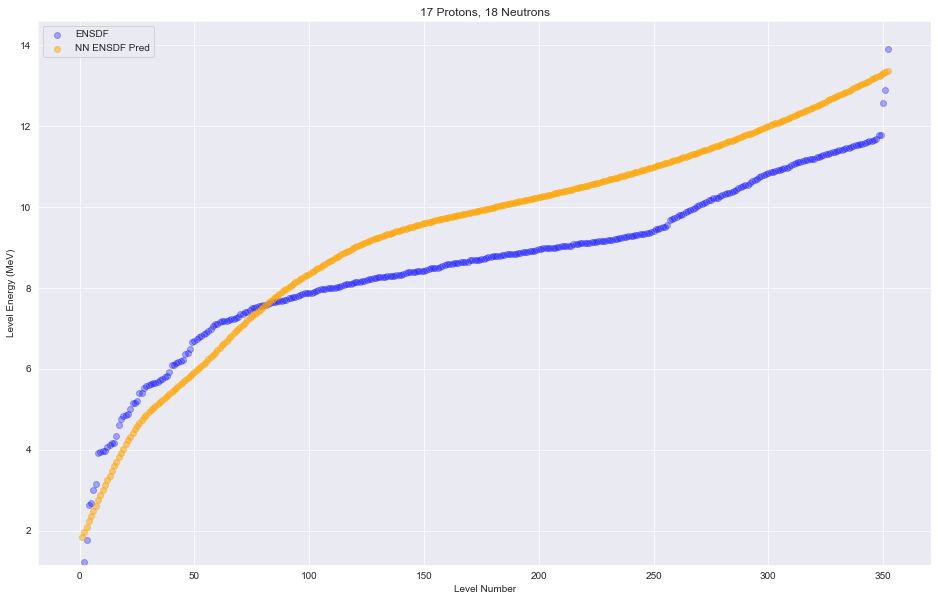

XS Tree vs EXFOR:
The MSE is:  1.2296875199631536
The R2-Score is:  0.7005113942848613


In [51]:
predicting_nuclear_xs(17, 35-17, size_histories['tiny_np'].model)

In [55]:
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# %%time
# def gpu_compile_and_fit(name, optimizer=None, max_epochs=10000, VERBOSE=0):
#     with strategy.scope():
#         lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#             0.001,
#             decay_steps=STEPS_PER_EPOCH*1000,
#             decay_rate=1,
#             staircase=False)
        
#         optimizer = tf.keras.optimizers.Adam(lr_schedule)
        
#         tiny_model = tf.keras.Sequential([
#             layers.Dense(16, activation='elu', input_shape=[len(x_train.keys())]),
#             layers.Dense(1)])

#         tiny_model.compile(optimizer=optimizer,
#                       loss='mse',
#                       metrics=['mae', 'mse'])

#         tiny_model.summary()
        
#         callbacks = [tfdocs.modeling.EpochDots(),
#             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
#             tf.keras.callbacks.TensorBoard(logdir/name)]

#         history = tiny_model.fit(
#             x_train.values, y_train.values,
#             batch_size=BATCH_SIZE, shuffle=True,
#             steps_per_epoch = STEPS_PER_EPOCH,
#             epochs=max_epochs, validation_split=0.2, verbose=VERBOSE,
#             callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
# size_histories_gpu['Tiny'] = gpu_compile_and_fit('sizes/Tiny', max_epochs=100)

In [52]:
%%time
with mirrored_strategy.scope():
    small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=[feature_len]),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)])
    size_histories['small'] = compile_and_fit(small_model, 'sizes/Small', x_train.values, y_train.values, max_epochs=100)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:10.8497,  mae:2.1589,  mse:10.8497,  val_loss:5.2859,  val_mae:1.4581,  val_mse:5.2853,  
....................................................................................................Wall time: 6min 8s


In [53]:
%%time
with mirrored_strategy.scope():
    medium_model = tf.keras.Sequential([
        layers.Dense(64, activation='elu', input_shape=[feature_len]),
        layers.Dense(64, activation='elu'),
        layers.Dense(64, activation='elu'),
        layers.Dense(1)])
    size_histories['medium']  = compile_and_fit(medium_model, "sizes/Medium", x_train.values, y_train.values, max_epochs=100)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:6.7786,  mae:1.6454,  mse:6.7786,  val_loss:4.9019,  val_mae:1.4136,  val_mse:4.9014,  
....................................................................................................Wall time: 6min 42s


In [54]:
%%time
with mirrored_strategy.scope():
    large_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=[feature_len]),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(1)])
    size_histories['large'] = compile_and_fit(large_model, 'sizes/Large', x_train.values, y_train.values, max_epochs=100)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:5.8997,  mae:1.5447,  mse:5.8997,  val_loss:4.6257,  val_mae:1.3643,  val_mse:4.6253,  
..........

In [73]:
# from bokeh.plotting import figure, output_file, show
# output_file("lines.html")

In [87]:
# # create a new plot with a title and axis labels
# p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# # add a line renderer with legend and line thickness
# p.line(np.linspace(0, 99, 100), pd.DataFrame(size_histories["large"].history)["mse"], legend="Temp.", line_width=2)

# # show the results
# show(p)

Text(0.5, 0, 'Epochs [Log Scale]')

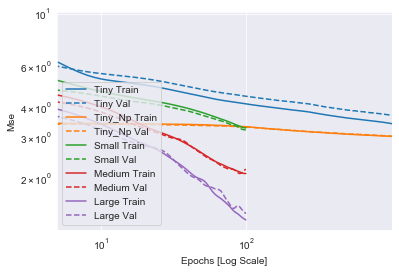

In [55]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")

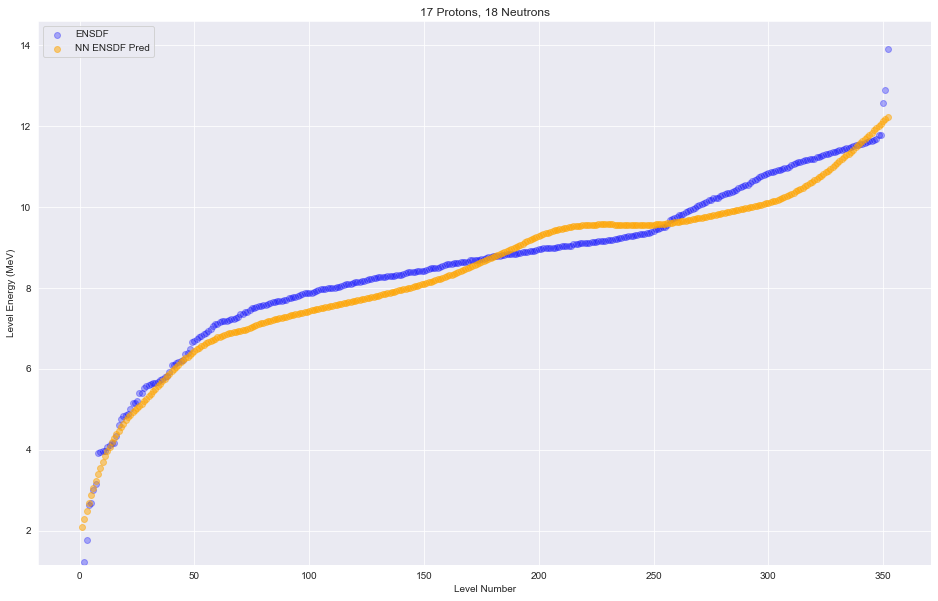

XS Tree vs EXFOR:
The MSE is:  0.1655840300057697
The R2-Score is:  0.9596722504944935


In [60]:
predicting_nuclear_xs(17, 35-17, size_histories['large'].model)

# Adding Regularization

In [62]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['tiny_np']

In [64]:
%%time
with mirrored_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=[feature_len]),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])

    regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', x_train.values, y_train.values, max_epochs=100)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.2295,  mae:1.5406,  mse:5.8580,  val_loss:5.8504,  val_mae:1.4093,  val_mse:4.6599,  
..........

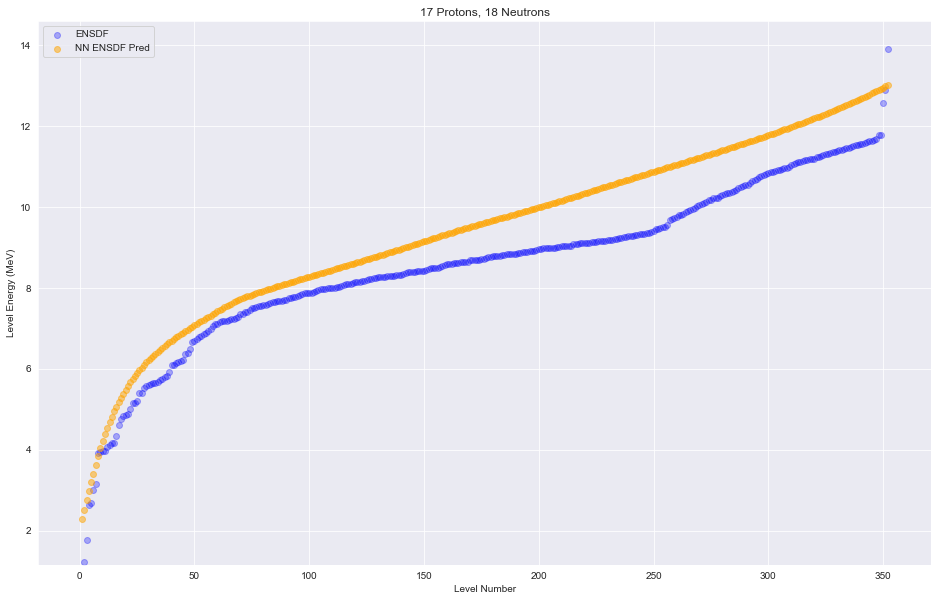

XS Tree vs EXFOR:
The MSE is:  0.8219001512935978
The R2-Score is:  0.7998274144025168


In [66]:
predicting_nuclear_xs(17, 35-17, regularizer_histories['l2'].model)

In [68]:
regularizer_histories['l2'].model.save_weights(".")

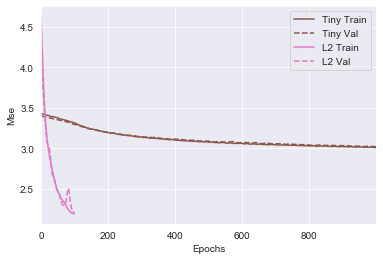

In [65]:
plotter.plot(regularizer_histories)

In [110]:
%%time
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               30208     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

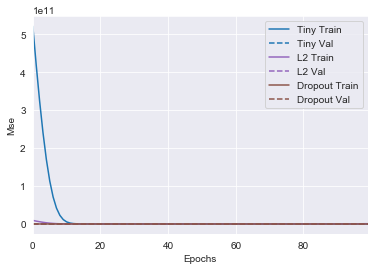

In [111]:
plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])

In [112]:
%%time
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=[len(x_train.keys())]),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined", df_cl_only.drop(["Data"], axis=1).values, df_cl_only["Data"].values, max_epochs=100)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               30208     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)              

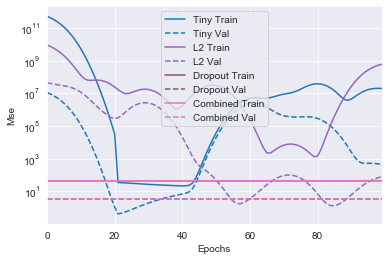

In [113]:
plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])
plt.yscale('log')

# Expanding L2 Model

In [216]:
activation_fn = "elu"
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=[len(x_train.keys())]),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1000, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation=activation_fn,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

l2_model_exp = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 512)               67584     
_________________________________________________________________
dense_120 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_121 (Dense)            (None, 1000)              513000    
_________________________________________________________________
dense_122 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_123 (Dense)            (None, 512)               512512    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 512)             

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


.........................................
Epoch: 100, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
.............

In [223]:
plotter.plot(l2_model_exp)

AttributeError: 'History' object has no attribute 'items'

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000255FC463648>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


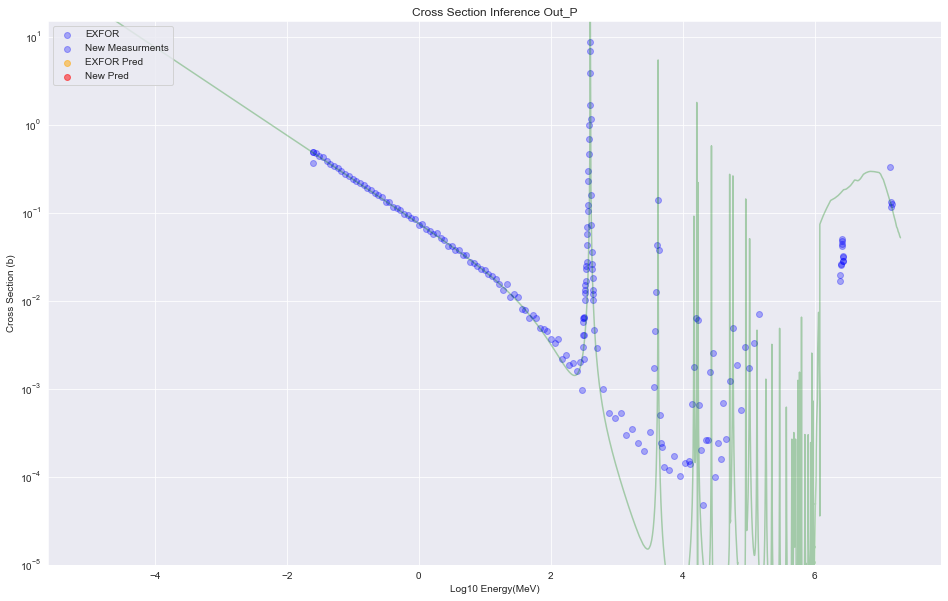

C:\Users\Pedro\Anaconda3\envs\data_mining_2\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000255FD995A08>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


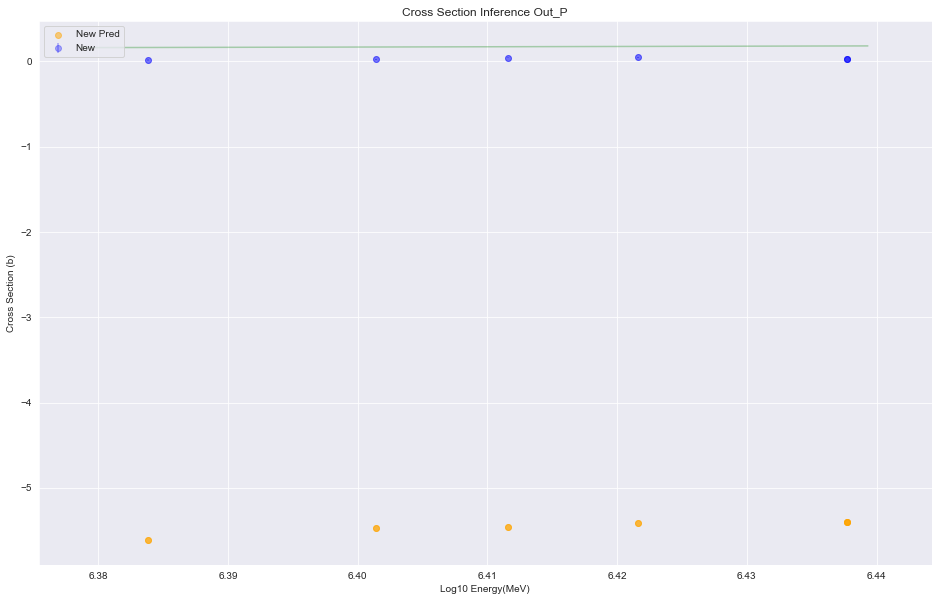

The MSE is:  57.67489321287504
The R2-Score is:  -69.9617736612562


In [88]:
predicting_nuclear_xs("Out_P", 17, 35, regularizer_histories['l2'].model, E_min=0.14, E_max=16)

# Other Strategy

In [46]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [40]:
mirrored_strategy = tf.distribute.MirroredStrategy()

def build_model():
    model = keras.Sequential([
        layers.Dense(250, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
#         layers.Dense(250, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.RMSprop(0.01)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model


def build_gpu_model():
    with mirrored_strategy.scope():
        model = keras.Sequential([
            layers.Dense(150, activation='relu', input_shape=[len(x_train.keys())]),
            layers.Dense(250, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)])

        optimizer = tf.keras.optimizers.RMSprop(0.001)

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
        return model

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [41]:
# model = build_model()
model = build_gpu_model()
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               19800     
_________________________________________________________________
dense_5 (Dense)              (None, 250)               37750     
_________________________________________________________________
dense_6 (Dense)       

In [47]:
with strategy.scope():
    model = keras.Sequential([
        layers.Dense(150, activation='relu', input_shape=[len(x_train.keys())]),
        layers.Dense(250, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [237]:
example_batch = x_train.values[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01175391],
       [-0.12772956],
       [-0.02639494],
       [-0.09360341],
       [ 0.00885992],
       [-0.17353778],
       [-0.08859062],
       [ 0.12745613],
       [-0.04629862],
       [ 0.01028054]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

In [318]:
example_batch = x_train.values[:10]
example_result = large_model.predict(example_batch)
example_result

array([[ 325.61108],
       [-148.68579],
       [2240.7556 ],
       [-578.2678 ],
       [ 138.15405],
       [1707.615  ],
       [ 563.96655],
       [3113.6619 ],
       [2050.1619 ],
       [1120.029  ]], dtype=float32)

# Training the Model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [48]:
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(
    x_train.values, y_train.values,
    batch_size=BATCH_SIZE, shuffle=True,
    epochs=EPOCHS, validation_split=0.2, verbose=1,
    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

# history = model.fit(
#     train_dataset,
#     epochs=EPOCHS, validation_data=val_dataset, verbose=1,
#     callbacks=[tfdocs.modeling.EpochDots()])

Train on 2901920 samples, validate on 725480 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
2885000/2901920 [============================>.] - ETA: 0s - loss: 356341206563.8958 - mae: 10315.1885 - mse: 356341153792.0000
Epoch: 0, loss:355940946036.8342,  mae:10357.3672,  mse:355940859904.0000,  val_loss:367352837936.4852,  val_mae:15887.8398,  val_mse:367352807424.0000,  
2901920/2901920 [==============================] - 17s 6us/sample - loss: 355940946036.8342 - mae: 10357.3672 - mse: 355940859904.0000 - val_loss: 367352837936.4852 - val_mae: 15887.8398 - val_mse: 367352807424.0000
Epoch 2/100
2901920/2901920 [==============================] - 10s 3us/sample - loss: 352079214548.1275 - ma

KeyboardInterrupt: 

In [239]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,4.242948e+10,1530.570190,4.242943e+10,2.113265e+10,1362.614014,2.113266e+10,95
96,4.244259e+10,1482.934570,4.244253e+10,2.487344e+10,1388.764771,2.487345e+10,96
97,3.968505e+10,1481.453369,3.968504e+10,2.306018e+10,1376.298096,2.306019e+10,97
98,4.138000e+10,1448.124268,4.137995e+10,1.991637e+10,1278.174805,1.991636e+10,98
99,4.304321e+10,1559.144775,4.304319e+10,3.451537e+10,1751.505493,3.451538e+10,99


In [240]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [XS]')

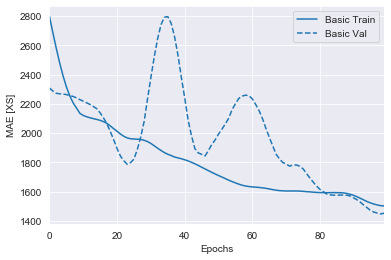

In [241]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim()
plt.ylabel('MAE [XS]')

Text(0, 0.5, 'MSE [XS^2]')

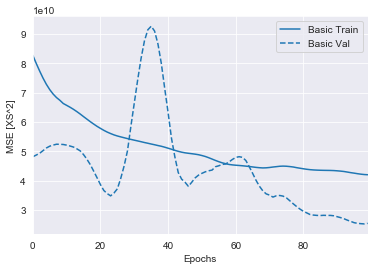

In [242]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim()
plt.ylabel('MSE [XS^2]')

In [233]:
loss, mae, mse = model.evaluate(x_test.values, y_test.values, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

906851/1 - 67s - loss: 24736169023.6159 - mae: 1594.6564 - mse: 49472081920.0000
Testing set Mean Abs Error: 1594.66 MPG


In [115]:
# DistributionPlot(y_cl, y_hat, "True", "Predicted", "Linear Model vs True Data")
predicting_nuclear_xs("Out_P", 17, 35, model, E_min=0.14, E_max=16)

AttributeError: 'dict' object has no attribute 'predict'

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.